### Build a QSAR model in 8 lines of Python
When I encounter a new dataset.  I often want to construct a simple model to get a quick idea of how easy or hard it will be to model the data.  Over the years, I've put together several scripts to do this.  Recently, I've come across a few Python packages that make this whole task a lot easier.  One thing I like about the workflow below is that it's flexible.  I can change the input format, the descriptors, or the machine learning model by changing one line of code.  This script doesn't take the place of rigorous validation but it provides a quick place to start.  

The code for this and other Practical Cheminformatics posts is available at [https://github.com/PatWalters/practical_cheminformatics_posts](https://github.com/PatWalters/practical_cheminformatics_posts)

In [1]:
!pip install rdkit pandas datamol molfeat numpy sklearn yellowbrick

In [96]:
import pandas as pd
import datamol as dm
from molfeat.calc import FPCalculator
from molfeat.trans import MoleculeTransformer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from yellowbrick.regressor import prediction_error, residuals_plot

**1.** Read the data into a [Pandas](https://pandas.pydata.org/) dataframe

In [97]:
filename = "https://raw.githubusercontent.com/PatWalters/yamc/main/data/Carbonic.smi"
df = pd.read_csv(filename,sep=" ",names=["SMILES","Name","pIC50"])

**2.** Instantiate a Fingerprint calculator from the awesome [molfeat](https://m2d2.io/blog/posts/introducing-molfeat-a-hub-of-molecular-featurizers/) package.  

In [87]:
calc = FPCalculator("ecfp")

**3.** Instantiate a molecule transfomer from molfeat.  This object takes a list of SMILES as input and returns descriptors.  It's very flexible and can run in parallel.  [Check it out!](https://molfeat-docs.datamol.io/stable/tutorials/types_of_featurizers.html)

In [88]:
trans = MoleculeTransformer(calc)

**4-5.** Calculate the fingerprints.  Note the use of the function from [datamol](https://datamol.io) that silences logging messages from the RDKit.  This is more polite version of my [rd_shut_the_hell_up](https://github.com/PatWalters/useful_rdkit_utils) function in useful_rdkit_utils. 

In [89]:
%%time
with dm.without_rdkit_log():
    df['fp'] = trans.transform(df.SMILES.values)

CPU times: user 67.4 ms, sys: 14.9 ms, total: 82.4 ms
Wall time: 109 ms


**6.** Split the data into training and test sets.  I like to do this with dataframes.  That way I don't have to remember the order in which train_X, train_y, test_X, and test_y are returned. 

In [90]:
train, test = train_test_split(df)

**7.** Instantiate an sklearn style regressor.  In this case I used [HistGradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html), which is the scikit-learn implementation of [LightGBM](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html).  You can easily plug in any scikit-learn compatible regressor like [RandomForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) or [XGBoost](https://xgboost.readthedocs.io/en/stable/python/python_intro.html). 

In [91]:
model = HistGradientBoostingRegressor()

**8.** Use [YellowBrick](https://www.scikit-yb.org/en/latest/) to build a model and visualize its performance. The **Loss** reported in the plot below is the [$R^2$](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) for the model.

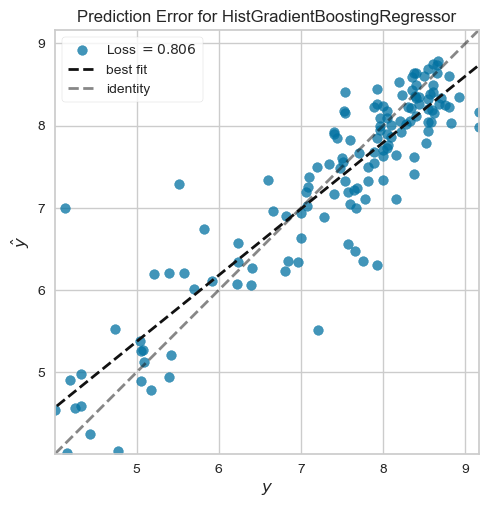

In [92]:
visualizer = prediction_error(model,np.stack(train.fp),train.pIC50,np.stack(test.fp),test.pIC50)

### Bonus
Plot the residuals for the training and test sets

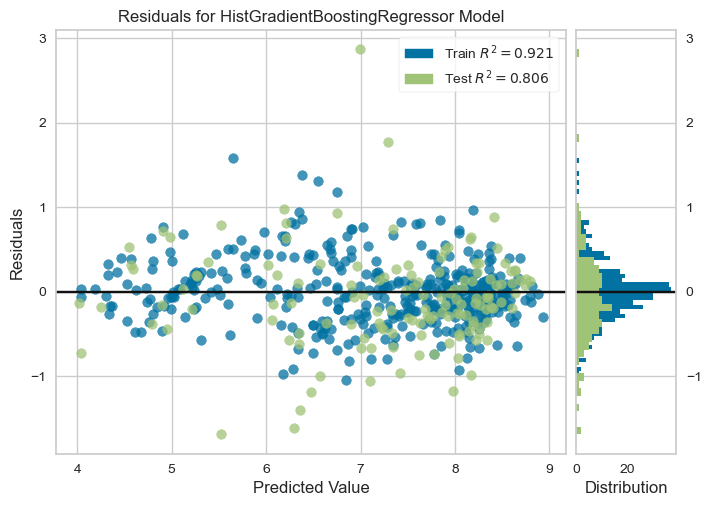

In [93]:
viz = residuals_plot(model,np.stack(train.fp), train.pIC50, np.stack(test.fp), test.pIC50, is_fitted=True)